# <center>医学论文助手</center>
<center><b>M</b>edical <b>M</b>anuscript <b>Helper</b></center>

<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#提出问题" data-toc-modified-id="提出问题-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>提出问题</a></span></li><li><span><a href="#理解数据" data-toc-modified-id="理解数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>理解数据</a></span><ul class="toc-item"><li><span><a href="#导入模块" data-toc-modified-id="导入模块-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>导入模块</a></span></li><li><span><a href="#设定相关参数" data-toc-modified-id="设定相关参数-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>设定相关参数</a></span></li><li><span><a href="#导入数据" data-toc-modified-id="导入数据-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>导入数据</a></span></li><li><span><a href="#数据基本信息" data-toc-modified-id="数据基本信息-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>数据基本信息</a></span><ul class="toc-item"><li><span><a href="#查看数据基本结构" data-toc-modified-id="查看数据基本结构-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>查看数据基本结构</a></span></li><li><span><a href="#设定数据类型" data-toc-modified-id="设定数据类型-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>设定数据类型</a></span></li><li><span><a href="#数据基本统计信息" data-toc-modified-id="数据基本统计信息-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>数据基本统计信息</a></span></li><li><span><a href="#查看指定数据" data-toc-modified-id="查看指定数据-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>查看指定数据</a></span></li></ul></li><li><span><a href="#数据可视化" data-toc-modified-id="数据可视化-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>数据可视化</a></span></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>数据预处理</a></span></li><li><span><a href="#特征选择" data-toc-modified-id="特征选择-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>特征选择</a></span></li><li><span><a href="#评估算法" data-toc-modified-id="评估算法-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>评估算法</a></span></li><li><span><a href="#预测" data-toc-modified-id="预测-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>预测</a></span></li></ul></li></ul></div>

## 提出问题

* 明确数据分析想解决或者了解的信息是什么？

## 理解数据

### 导入模块

In [1]:
import numpy as np
import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 设定相关参数

In [2]:
# pd.set_option('precision', 2)  # 显示小数位数
# pd.set_option('max_rows', 11)  # 显示最大行数, describe需要11行
# pd.set_option('max_colwidth',40) # 最大列宽
# pd.reset_option('precision')  # 重置显示设置，其余选项类似
# %config InlineBackend.figure_format = 'svg'

### 导入数据

* 将pd.read_csv('...')内数据文件链接替换为相关数据文件的网址
* 数据第一列为分组标识

In [3]:
dataframe = pd.read_csv('./data/duct/duct.csv')
# dataframe = pd.read_excel('./data/duct/duct.xlsx')

### 数据基本信息

#### 查看数据基本结构

In [4]:
dataframe.head()
# dataframe.head(), dataframe.tail(), dataframe.index, dataframe.columns, dataframe.values
# dataframe.T  # 行列互换
# dataframe.sort_values(by='age')  # 按列值排序
# dataframe[dataframe.age < 35]  # 按条件查看数据

,group,age,menopause,gestation,pain,ectasia,multiple,distance,size
0,0,47,0,1,1,0,1,0.0,1.0
1,0,47,0,1,1,0,1,0.0,0.0
2,0,44,0,1,0,0,1,0.0,0.0
3,0,44,0,1,0,0,1,NaN,1.0
4,0,44,0,1,0,0,1,0.0,1.0


#### 设定数据类型

In [35]:
# dataframe[['group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']] = dataframe[[
#     'group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']].astype('category')
# category, int64, float64, datetime64, object
dataframe.info()
# 确认数据结构

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 9 columns):
group        474 non-null int64
age          474 non-null int64
menopause    474 non-null int64
gestation    474 non-null int64
pain         474 non-null int64
ectasia      474 non-null int64
multiple     474 non-null int64
distance     393 non-null float64
size         468 non-null float64
dtypes: float64(2), int64(7)
memory usage: 33.4 KB


#### 数据基本统计信息

In [6]:
dataframe.describe(include='all')

,group,age,menopause,gestation,pain,ectasia,multiple,distance,size
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,393.000000,468.000000
mean,0.462025,41.221519,0.128692,0.860759,0.179325,0.080169,0.601266,0.447837,0.502137
std,0.499083,10.785016,0.335212,0.346563,0.384029,0.271841,0.490155,0.497905,0.500530
min,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,42.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,47.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,77.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
dataframe.age.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

count    474.000000
mean      41.221519
std       10.785016
min       12.000000
10%       26.000000
20%       32.000000
30%       37.000000
40%       40.000000
50%       42.000000
60%       44.000000
70%       46.000000
80%       48.000000
90%       53.000000
99%       70.350000
max       77.000000
Name: age, dtype: float64

In [7]:
# dataframe.hist(grid=False, bins=20, figsize=(10,10), layout=(3,3));

---

#### 查看指定数据

In [51]:
# dataframe['group'].value_counts()
# dataframe.groupby('group').mean()
# dataframe[dataframe.age > 70]
dataframe[['size','group']].groupby('size').mean()

,group
size,
0.0,0.549356
1.0,0.361702


* 数据相关性

In [9]:
# dataframe.corr(method='spearman')
# 'pearson', 'kendall', 'spearman'

* 分组情况（按第一列分组）

In [10]:
# chisq = data.groupby([data['group'], data['gestation']]).size()
# print(chisq)

In [11]:
# pd.crosstab(data['group'], data['gestation'], margins=True)

* 卡方检验（2*2表格）
    - 所有的理论数T≥5并且总样本量n≥40，用Pearson卡方进行检验。
    - 如果理论数T＜5但T≥1，并且1≥40，用连续性校正的卡方进行检验。
    - 如果有理论数T＜1或n＜40，则用Fisher’s检验。
    - 非2*2表格直接使用stats.chi2_contingency(chisq_matrix)

* R×C表卡方检验应用条件：
    - R×C表中理论数小于5的格子不能超过1／5；
    - 不能有小于1的理论数。如果实验中有不符合R×C表的卡方检验，可以通过增加样本数、列合并来实现。

In [12]:
# chisq_matrix = np.array([[chisq[0, 0], chisq[0, 1]],
#                          [chisq[1, 0], chisq[1, 1]]])
# stats.chi2_contingency(chisq_matrix, correction=False)  # Pearson
# stats.chi2_contingency(chisq_matrix) # 连续性校正
# stats.fisher_exact(chisq_matrix)

### 数据可视化

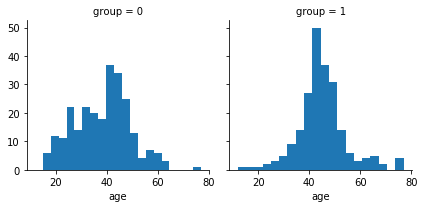

In [61]:
g = sns.FacetGrid(dataframe, col='group')
g.map(plt.hist, 'age',bins=20)

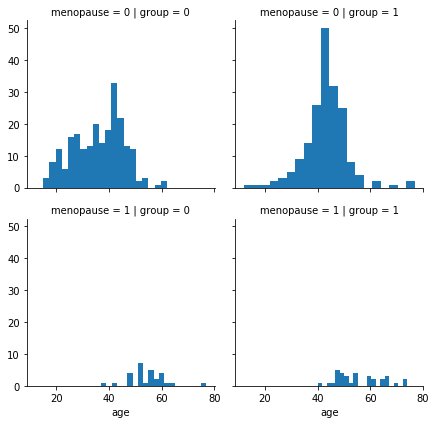

In [62]:
grid = sns.FacetGrid(dataframe, col='group', row='menopause')
grid.map(plt.hist, 'age', bins=20)
grid.add_legend();

d:\github\miniconda3\envs\mmhelper\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
d:\github\miniconda3\envs\mmhelper\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
d:\github\miniconda3\envs\mmhelper\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


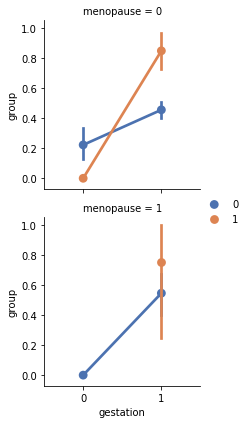

In [67]:
grid = sns.FacetGrid(dataframe, row='menopause')
grid.map(sns.pointplot, 'gestation', 'group', 'ectasia', palette='deep')
grid.add_legend()

* 单变量密度图

In [13]:
# data.plot(
#     kind='density',
#     subplots=True,
#     figsize=(10, 10),
#     layout=(3, 3),
#     sharex=False)

* 单变量箱图

In [14]:
# data.plot(
#     kind='box', subplots=True, figsize=(10, 10), layout=(3, 3), sharex=False)

* 多变量相关矩阵图

In [15]:
# import numpy as np
# correlations = data.corr()
# fig = pyplot.figure()
# ax = fig.add_subplot('111')
# ax.matshow(correlations, vmin=-1, vmax=1)
# ticks = np.arange(0, 9, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(data.columns)
# ax.set_yticklabels(data.columns)
# fig.set_size_inches(10, 10)

* 散点矩阵图

In [16]:
# pd.plotting.scatter_matrix(data, figsize=(15,15));

### 数据预处理

* 数据缺失值处理

In [17]:
data = dataframe.dropna()

* 分离数据

In [18]:
from sklearn.model_selection import train_test_split
array = data.values
X = array[:, 1:]
y = array[:, 0]

1. 调整尺度

In [19]:
# from sklearn.preprocessing import MinMaxScaler
# transformer = MinMaxScaler(feature_range=(0,1))
# X = transformer.fit_transform(X)

2. 正态化数据

In [20]:
# from sklearn.preprocessing import StandardScaler
# transformer = StandardScaler().fit(X)
# X = transformer.transform(X)

3. 标准化数据

In [21]:
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X)
# X = transformer.transform(X)

4. 二值数据

In [22]:
# from sklearn.preprocessing import Binarizer
# transformer = Binarizer().fit(X)
# X = transformer.transform(X)

### 特征选择

* 单变量特征选择

In [23]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# testchi = chi2(X, Y)
# test = SelectKBest(score_func=chi2, k=2)
# fit = test.fit(X, Y)
# print(fit.scores_)
# features = fit.transform(X)
# test.get_support()

* 递归特征消除（RFE）

In [24]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(solver='lbfgs')
# rfe = RFE(model, 3)
# fit = rfe.fit(X, Y)
# print(fit.n_features_)
# print(fit.support_)
# print(fit.ranking_)

* 主要成分分析（PCA）

In [25]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# fit = pca.fit(X)
# print(fit.explained_variance_ratio_)
# print(fit.components_)

* 特征重要性

In [26]:
# from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier(n_estimators=100)
# fit = model.fit(X, Y)
# print(fit.feature_importances_)

### 评估算法

* 数据分组

In [27]:
testsize = 0.2
seed = 4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testsize, random_state=seed)

* 评估模型

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

models = {}
models['LR'] = LogisticRegression(solver='liblinear')
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['SVM'] = SVC(gamma='scale')
models['XGB'] = XGBClassifier()

results = []
for key in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(
        models[key], X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)


* 箱图比较算法

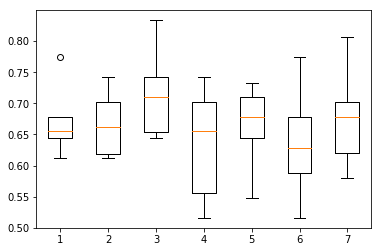

In [29]:
plt.boxplot(results);

### 预测

In [30]:
# svm = SVC(gamma='scale')
# svm.fit(X=X_train, y=y_train)
# predictions = svm.predict(X_test)
models['XGB'].fit(X_train, y_train)
predictions = models['XGB'].predict(X_test)

In [31]:
accuracy_score(y_test, predictions)

0.7435897435897436

In [32]:
confusion_matrix(y_test, predictions)

array([[38, 12],
       [ 8, 20]], dtype=int64)

In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        50
         1.0       0.62      0.71      0.67        28

   micro avg       0.74      0.74      0.74        78
   macro avg       0.73      0.74      0.73        78
weighted avg       0.75      0.74      0.75        78

